In [74]:
import models
import torch
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Infering parameters of sigmoid IRF

In [75]:
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

num_students, num_questions, num_concepts = 100, 100, 5

guess_prob = 1/num_concepts

# Simulated data for quick testing.
Y = (torch.randn(num_students, num_questions, device=device, dtype=dtype) >= 0).float()

# Randomly initialize weights
A = torch.randn(num_students, num_concepts, device=device, dtype=dtype, requires_grad=True)
D = torch.randn(num_questions, num_concepts, device=device, dtype=dtype, requires_grad=True)
concept = np.random.choice(list(range(num_concepts)), num_questions)

train_acc = []
precision = []
losses = []

learning_rate = 1000

for t in range(500):
    # Forward pass: compute predicted y
    scores = models.two_param_sigmoid_irf(A[:, concept], D[range(D.shape[0]), concept], guess_prob)

    # Compute and print loss
    loss = f.binary_cross_entropy_with_logits(scores, Y)
    
    preds = (scores >= 0.5).float()
    
    losses.append(loss.item())
    train_acc.append(torch.sum(Y == preds).item() / (Y.shape[0] * Y.shape[1]))
    precision.append(torch.sum(Y.int() & preds.int()).item() / torch.sum(preds).item())

    # Backprop to compute gradients of w1 and w2 with respect to loss
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        A -= learning_rate * A.grad
        D -= learning_rate * D.grad
        
        # Manually zero the gradients after updating weights
        A.grad.zero_()
        D.grad.zero_()

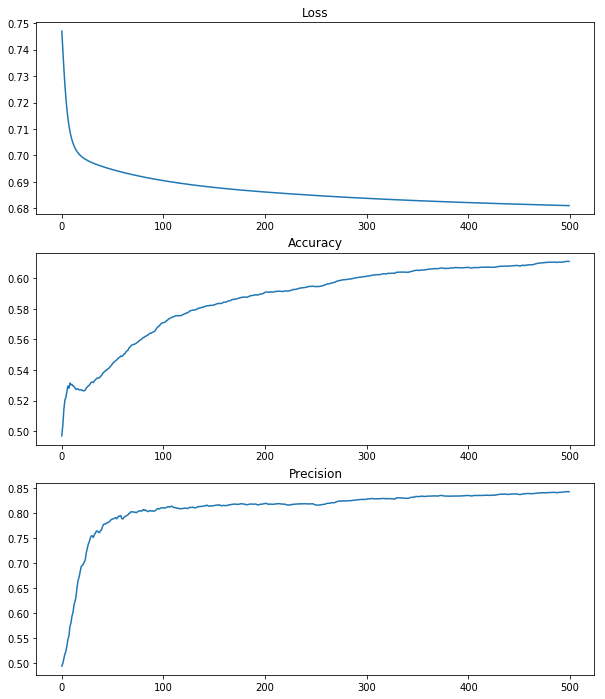

In [77]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.title('Loss')
plt.plot(losses)
plt.subplot(312)
plt.title('Accuracy')
plt.plot(train_acc)
plt.subplot(313)
plt.title('Precision')
plt.plot(precision)
plt.show()

## Infering parameters of Floored exponential IRF

In [78]:
# Randomly initialize weights
A = torch.randn(num_students, num_concepts, device=device, dtype=dtype, requires_grad=True)
D = torch.randn(num_questions, num_concepts, device=device, dtype=dtype, requires_grad=True)
# We fix lambda instead of inferring it along with A, D because behavior goes haywire.
l = torch.tensor(10, device=device, dtype=dtype, requires_grad=False)
concept = np.random.choice(list(range(num_concepts)), num_questions)

train_acc = []
precision = []
losses = []

learning_rate = 50

for t in range(500):
    # Forward pass: compute predicted y
    scores = models.floored_exp_irf(A[:, concept], D[range(D.shape[0]), concept], l, guess_prob)

    # Compute and print loss
    loss = f.binary_cross_entropy_with_logits(scores, Y)
    
    preds = (scores >= 0.5).float()
    
    losses.append(loss.item())
    train_acc.append(torch.sum(Y == preds).item() / (Y.shape[0] * Y.shape[1]))
    precision.append(torch.sum(Y.int() & preds.int()).item() / np.maximum(1, torch.sum(preds).item()))

    # Backprop to compute gradients of w1 and w2 with respect to loss
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        A -= learning_rate * A.grad
        D -= learning_rate * D.grad
        #l -= learning_rate * l.grad
        
        # Manually zero the gradients after updating weights
        A.grad.zero_()
        D.grad.zero_()
        #l.grad.zero_()

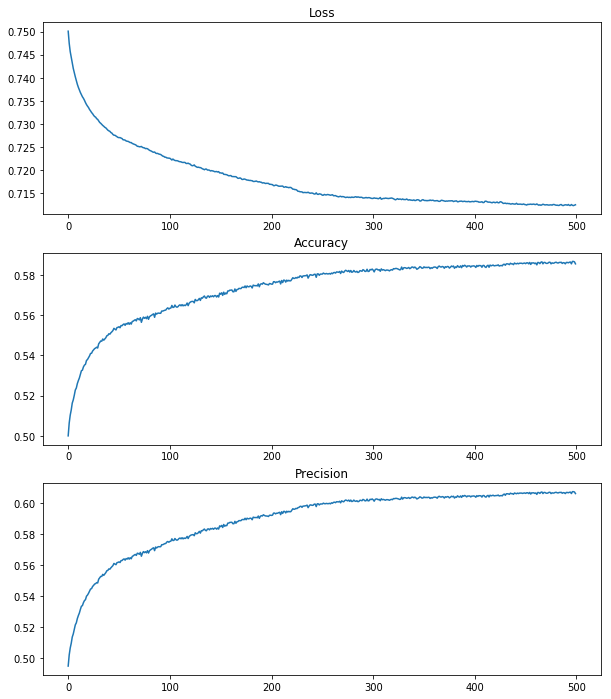

In [79]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.title('Loss')
plt.plot(losses)
plt.subplot(312)
plt.title('Accuracy')
plt.plot(train_acc)
plt.subplot(313)
plt.title('Precision')
plt.plot(precision)
plt.show()

In [80]:
train_acc[-1]

0.5856